In [1]:
# %% Import packages
from pprint import pprint
from itertools import chain, compress, product
from functools import reduce, partial, lru_cache
from glob import iglob
from typing import Generator

from numba import jit
from yaml import safe_load
from cytoolz import compose, merge_with
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row, DataFrame, functions as f
from dltools import load_combiner
from dltools.sacla import restructure, load_analyzer

In [2]:
# %% Load PySpark
builder = (
    SparkSession
    .builder
    .config("spark.executor.memory", "16g")
    .config("spark.driver.memory", "16g")
    .config("spark.driver.maxResultSize", "4g")
    .config(        
        "spark.jars.packages",
        "org.mongodb.spark:mongo-spark-connector_2.12:2.4.0,"
        "org.diana-hep:spark-root_2.11:0.1.15,"
    )
)

print("Loading PySpark...")
spark = builder.getOrCreate()
print("Done!")

Loading PySpark...
Done!


In [3]:
# %% Load data
from pyspark.sql.types import (
    ArrayType, BooleanType, LongType, StructField, StructType, DoubleType,
)
from dltools import SpkHits


print("Loading data...")
df = (
    spark
    .read
    .format("com.mongodb.spark.sql.DefaultSource")
    .option("uri", "mongodb://mongodb/sacla_2017b8065.resorted")
    .option("pipeline", """[
        {
            $match: {
                aq: {$in: [35, 36]},
            },
        },
        {
            $project: {
                tag: true,
                hits: {
                    $filter: {
                        input: "$hits",
                        as: "item",
                        cond: {$and: [{$lte: ["$$item.flag", 6]},
                                      {$or: [{$ne: ["$$item.as_.C1p", undefined]},
                                             {$ne: ["$$item.as_.I1p", undefined]},
                                             {$ne: ["$$item.as_.I2p", undefined]}]}]},
                    },
                },
            },
        },
    ]""")
    .schema(
        StructType([
            StructField("tag", LongType()),
            StructField("hits", SpkHits)
        ])
    )
    .load()
)
df.printSchema()
print("Done!")

Loading data...
root
 |-- tag: long (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- t: double (nullable = false)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- as_: map (nullable = false)
 |    |    |    |-- key: string
 |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |-- ke: double (nullable = false)
 |    |    |-- flag: integer (nullable = true)

Done!


In [4]:
import typing
import pyspark
from dltools.cov import cov3d_complicated


def ishit0(hit: pyspark.sql.Row) -> bool:
    return "C1p" in hit["as_"]


def ishit1(hit: pyspark.sql.Row) -> bool:
    return "I2p" in hit["as_"]


def ishit2(hit: pyspark.sql.Row) -> bool:
    return "I1p" in hit["as_"]


combined = cov3d_complicated(
    df, ishit0, ishit1, ishit2,
    npart=60,
    opt1={
        "npart": 12,
    },
    opt2={
        "fraction": 0.2,
        "npart": 60,
    },
    opt3={
        "fraction": 0.02,
        "npart": 60,
    },
)

In [5]:
def hist_ker(rows: typing.List[pyspark.sql.Row]) -> typing.List[np.ndarray]:
    ret, *_ = np.histogram(
        [
            r["hit0"]["as_"]["C1p"]["ke"]
            + r["hit1"]["as_"]["I2p"]["ke"]
            + r["hit2"]["as_"]["I1p"]["ke"]
            for r in rows
            if (-200 < (r["hit0"]["as_"]["C1p"]["px"] + r["hit1"]["as_"]["I2p"]["px"] + r["hit2"]["as_"]["I1p"]["px"]) < 200
                and -100 < (r["hit0"]["as_"]["C1p"]["py"] + r["hit1"]["as_"]["I2p"]["py"] + r["hit2"]["as_"]["I1p"]["py"]) < 100
                and -100 < (r["hit0"]["as_"]["C1p"]["pz"] + r["hit1"]["as_"]["I2p"]["pz"] + r["hit2"]["as_"]["I1p"]["pz"]) < 100)
        ],
        bins=np.linspace(0, 100, 101),
    )
    return [ret]

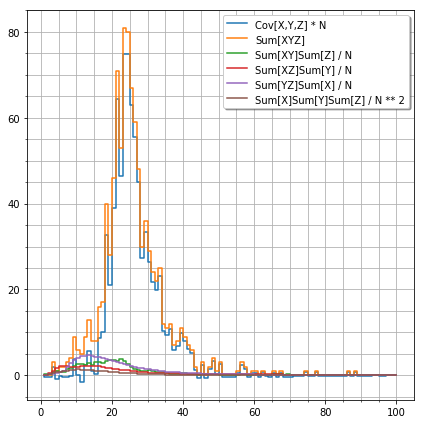

In [6]:
x = np.linspace(0, 100, 101)[1:]
n = combined(hist_ker)["N"]

plt.figure(figsize=(6, 6))
plt.step(
    x, combined(hist_ker)["Cov[X,Y,Z]"] * n,
    label="Cov[X,Y,Z] * N",
)
plt.step(
    x, combined(hist_ker)["Sum[XYZ]"],
    label="Sum[XYZ]",
)
plt.step(
    x, combined(hist_ker)["Sum[XY]Sum[Z]"] / n,
    label="Sum[XY]Sum[Z] / N",
)
plt.step(
    x, combined(hist_ker)["Sum[XZ]Sum[Y]"] / n,
    label="Sum[XZ]Sum[Y] / N",
)
plt.step(
    x, combined(hist_ker)["Sum[YZ]Sum[X]"] / n,
    label="Sum[YZ]Sum[X] / N",
)
plt.step(
    x, combined(hist_ker)["Sum[X]Sum[Y]Sum[Z]"] / n ** 2,
    label="Sum[X]Sum[Y]Sum[Z] / N ** 2",
)

# plt.xlim(0, 100)
# plt.ylim(0, None)
plt.minorticks_on()
plt.grid(True, which="both")
plt.legend(shadow=True)

plt.tight_layout()
plt.show()